# PREAMBLE CODE

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
torch.manual_seed(42)

from torch.utils.data import DataLoader
from torchvision import datasets, transforms
from models.simple_FashionMNIST import simple_FashionMNIST

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import seaborn as sns
from IPython.display import clear_output, display
import time

## DATASETS

### MNIST loader setup

In [2]:
mnist_test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=1, shuffle=True)

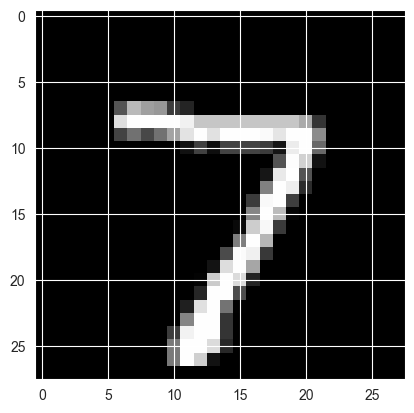

In [3]:
mnist_ex_img = mnist_test_loader.dataset[0][0].squeeze()
plt.imshow(mnist_ex_img, cmap='gray')

### FashionMNIST loader setup

In [4]:
fashionmnist_test_loader  = torch.utils.data.DataLoader(
    datasets.FashionMNIST('data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])
    ),
    batch_size=1, shuffle=True)

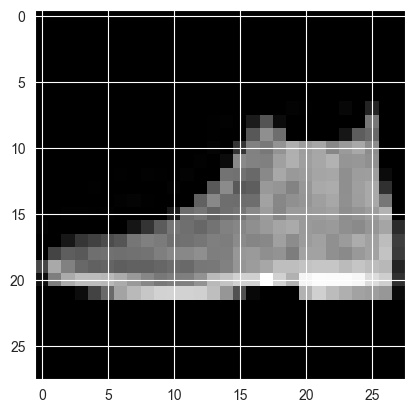

In [5]:
fashionmnist_ex_img = fashionmnist_test_loader.dataset[0][0].squeeze()
plt.imshow(fashionmnist_ex_img, cmap='gray')

### 3rd dataset setup

In [6]:
cifar_loader = torch.utils.data.DataLoader(
    datasets.CIFAR10('data', 
                   train=False, 
                   download=True, 
                   transform=transforms.Compose([
                       transforms.ToTensor(), 
                       transforms.Normalize((0.4914, 0.4822, 0.4465), (0.247, 0.243, 0.261))
                   ])
    ),
    batch_size=1, shuffle=True)

Files already downloaded and verified


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.7830755..2.0985878].


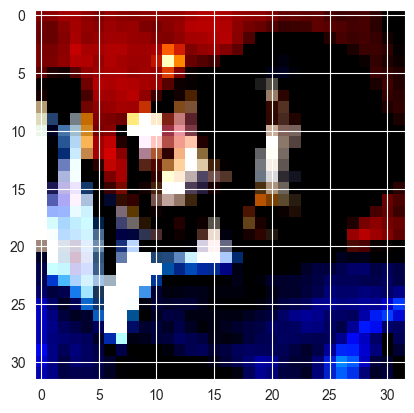

In [7]:
cifar_loader_ex_img = cifar_loader.dataset[0][0].squeeze()
plt.imshow(np.transpose(cifar_loader_ex_img.numpy(), (1, 2, 0)))

### Pre-trained model loading for MNIST

In [8]:
class LeNet(nn.Module):
    def __init__(self):
        super(LeNet, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, 3, 1)
        self.conv2 = nn.Conv2d(32, 64, 3, 1)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(9216, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        x = self.conv1(x)
        x = F.relu(x)
        x = self.conv2(x)
        x = F.relu(x)
        x = F.max_pool2d(x, 2)
        x = self.dropout1(x)
        x = torch.flatten(x, 1)
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout2(x)
        x = self.fc2(x)
        output = F.log_softmax(x, dim=1)
        return output

In [9]:
mnist_model = LeNet().to(device)
mnist_model_path = r'models/lenet_mnist_model.pth'
mnist_model.load_state_dict(torch.load(mnist_model_path, map_location=device))

<All keys matched successfully>

In [10]:
mnist_model.eval()

LeNet(
  (conv1): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (dropout1): Dropout(p=0.25, inplace=False)
  (dropout2): Dropout(p=0.5, inplace=False)
  (fc1): Linear(in_features=9216, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)

### Pre-trained model loading for FashionMNIST

In [11]:
fashionmnist_model = simple_FashionMNIST("models/simple_FashionMNIST.pth")
fashionmnist_model_target = fashionmnist_model.model.to(device)  # Ensure the model is moved to the device
fashionmnist_test_loader = fashionmnist_model.testloader

Running on cpu.
Model weights loaded successfully


### Pre-trained model loading for CIFAR10

In [12]:
#from models.resNet import ResNet20
#target_mdl = ResNet20()
#model = target_mdl.model
#device = target_mdl.device
#test_loader = target_mdl.testloader

## Some helper functions

In [13]:
# from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html

def denorm(batch, mean=[0.1307], std=[0.3081]):
    """
    Convert a batch of tensors to their original scale.

    Args:
        batch (torch.Tensor): Batch of normalized tensors.
        mean (torch.Tensor or list): Mean used for normalization.
        std (torch.Tensor or list): Standard deviation used for normalization.

    Returns:
        torch.Tensor: batch of tensors without normalization applied to them.
    """
    if isinstance(mean, list):
        mean = torch.tensor(mean).to(device)
    if isinstance(std, list):
        std = torch.tensor(std).to(device)

    return batch * std.view(1, -1, 1, 1) + mean.view(1, -1, 1, 1)

In [14]:
# MODIFED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog:
# added algo parameter to the function signature and call to the algo function as to define test funct only once and call it with the desired attack algo
# added alpha parameter to the function signature as to define test funct only once and call it with the desired step size
# added num_iter parameter to the function signature
# adapted function returns to fit running function
###
# if statement for FSGM (needs some tinkering cuz the code is too long) # fixed! (also previous code gave problems with step size plotting)
# added iteration time and iteration accuracy lists to return them for plotting -> used time.time instead of cpu time since ig we'll run final code on colab
# made the printing of epsilon and accuracy being held by RUN ### also to be deleted when I fix the history function

def test(model, device, test_loader, epsilon, algo, alpha, num_iter):
    model.eval()
    correct = 0
    adv_examples = []
    iteration_accuracies = []
    step_sizes = []
    iteration_times = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denorm(data)

        start_time = time.time()
        if algo == 'FSGM_attack':
            perturbed_data = FSGM_attack(data_denorm, epsilon, data_grad)
        elif algo == PGD_const:
            perturbed_data = PGD_const(model, data_denorm, target, epsilon, alpha, num_iter)
        else:
            perturbed_data = algo(model, data_denorm, target, epsilon, num_iter, alpha)
        iteration_time = time.time() - start_time

        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        output = model(perturbed_data_normalized)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        iteration_accuracies.append(correct / float(len(test_loader)))
        step_sizes.append(epsilon if algo == 'FSGM_attack' else alpha)
        iteration_times.append(iteration_time)

    final_acc = correct / float(len(test_loader))
    return final_acc, adv_examples, iteration_accuracies, step_sizes, iteration_times


In [15]:
def plot_metrics(epsilons, accuracies_dict, iteration_accuracies_dict, iteration_times_dict, step_sizes_dict, num_iter):
    fig, axs = plt.subplots(4, 1, figsize=(8, 20))

    # Accuracy vs Epsilon
    for dataset, accuracies in accuracies_dict.items():
        sns.lineplot(ax=axs[0], x=epsilons, y=accuracies, label=f"{dataset}", linewidth=0.75, errorbar=None, marker='x')
    axs[0].set_xlabel('Epsilon', fontsize=14)
    axs[0].set_ylabel('Accuracy', fontsize=14)
    axs[0].set_title("Accuracy vs Epsilon", fontsize=16)
    axs[0].legend()

    # Accuracy vs Iteration
    for dataset, iteration_accuracies in iteration_accuracies_dict.items():
        sns.lineplot(ax=axs[1], x=np.arange(len(iteration_accuracies)), y=iteration_accuracies, label=f"{dataset}")
    axs[1].set_title('Accuracy vs Iteration')
    axs[1].set_xlabel('Iteration')
    axs[1].set_ylabel('Accuracy')
    axs[1].legend()

    # Time vs Iteration
    for dataset, iteration_times in iteration_times_dict.items():
        cumulative_times = np.cumsum(iteration_times)
        sns.lineplot(ax=axs[2], x=np.arange(len(cumulative_times)), y=cumulative_times, label=f"{dataset}", linewidth=0.75)
    axs[2].set_title('Time vs Iteration')
    axs[2].set_xlabel('Iteration')
    axs[2].set_ylabel('Cumulative Time (s)')
    axs[2].legend()

    # Step Size Behavior
    for dataset, step_sizes in step_sizes_dict.items():
        sns.lineplot(ax=axs[3], x=, y=step_sizes, label=f"{dataset}")
    axs[3].set_title('Step Size Behavior')
    axs[3].set_xlabel('Iteration')
    axs[3].set_ylabel('Step Size')
    axs[3].legend()

    plt.tight_layout()
    plt.show()

In [16]:
def history(epsilons, accuracies_dict, iteration_accuracies_dict, iteration_times_dict, step_sizes_dict):
    metrics = []
    for dataset_name in accuracies_dict.keys():
        for i, epsilon in enumerate(epsilons):
            metrics.append({
                "Dataset": dataset_name,
                "Epsilon": epsilon,
                "Accuracy": accuracies_dict[dataset_name][i],
                "Iteration_Time": iteration_times_dict[dataset_name][i] if i < len(iteration_times_dict[dataset_name]) else None,
                "Step_Size": step_sizes_dict[dataset_name][i] if i < len(step_sizes_dict[dataset_name]) else None,
            })
    metrics_df = pd.DataFrame(metrics)
    display(metrics_df)

In [17]:
# MODIFED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog: made it a function instead of the whole code so that we slim the code

def plot_examples(examples, epsilons):
    cnt = 0
    plt.figure(figsize=(8, 10))
    for i in range(len(epsilons)):
        for j in range(len(examples[i])):
            cnt += 1
            plt.subplot(len(epsilons), len(examples[0]), cnt)
            plt.xticks([], [])
            plt.yticks([], [])
            if j == 0:
                plt.ylabel(f"Eps: {epsilons[i]}", fontsize=14)
            orig, adv, ex = examples[i][j]
            plt.title(f"{orig} -> {adv}")
            plt.imshow(ex, cmap="gray")
    plt.tight_layout()
    plt.show()

In [18]:
model_dict = {
    "MNIST": mnist_model,
    "FashionMNIST": fashionmnist_model_target  
    # "CIFAR10":
}

test_loader_dict = {
    "MNIST": mnist_test_loader,
    "FashionMNIST": fashionmnist_test_loader
    # "CIFAR10":
}

In [19]:
# function runs the attack for each epsilon and plots the accuracy, and at the end plots the examples

def RUN(model_dict, device, test_loader_dict, algo, num_iter, epsilons, alpha):
    accuracies_dict, examples_dict = {}, {}
    all_iteration_accuracies_dict, all_step_sizes_dict, all_iteration_times_dict = {}, {}, {}

    for dataset_name, model in model_dict.items():
        test_loader = test_loader_dict[dataset_name]
        accuracies, examples, all_iteration_accuracies, all_step_sizes, all_iteration_times = [], [], [], [], []

        print(f"Dataset: {dataset_name}")
        for eps in epsilons:
            acc, ex, iteration_accuracies, step_sizes, iteration_times = test(model, device, test_loader, eps, algo, alpha, num_iter)
            accuracies.append(acc)
            examples.append(ex)
            all_iteration_accuracies.extend(iteration_accuracies)
            all_step_sizes.extend(step_sizes)
            all_iteration_times.extend(iteration_times)
            print(f"Epsilon: {eps:.2f}, Accuracy: {acc:.4f}")

        accuracies_dict[dataset_name] = accuracies
        examples_dict[dataset_name] = examples
        all_iteration_accuracies_dict[dataset_name] = all_iteration_accuracies
        all_step_sizes_dict[dataset_name] = all_step_sizes
        all_iteration_times_dict[dataset_name] = all_iteration_times

    plot_metrics(epsilons, accuracies_dict, all_iteration_accuracies_dict, all_iteration_times_dict, all_step_sizes_dict, num_iter)
    history(epsilons, accuracies_dict, all_iteration_accuracies_dict, all_iteration_times_dict, all_step_sizes_dict)

## Optimization ''hyperparams'' setup

### Perturbation set bounds

In [20]:
epsilons = [0, .05, .1, .15, .2, .25, .3, .35]

### Number of iterations

In [21]:
num_iter = 5

### Constant step sizes

##### Unit step size

In [22]:
alpha_unit = 1

##### Lipschitz constant dependent step size

In [23]:
def lipschitz_constant(model):
    L = 0  # initialize

    for layer in model.children():
        if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
            
            weight = layer.weight.data # extract weight data
            
            singular_values = torch.svd(weight).S     # as we did initially in the homework, we approximate the Lipschitz
            L = max(L, singular_values.max().item())  # constant as the maximum singular value of the weight matrix
    
    return L

# particular step size computed inside algo function

### Adaptive step sizes

##### Diminishing step size

In [24]:
def alpha_dim(num_iter):
    alphas = [2 / (k + 2) for k in range(num_iter)] # defined as a list cuz it's easier to call the i-th element
    return alphas

##### Exact line search

From Rinaldi's survey paper:

The exact line search method aims to find the optimal step size $ \( \alpha \)$  that minimizes the objective function along the direction of the gradient descent.

$ \[ \alpha_k = \min_{\alpha \in [0, \alpha_{\text{max}}^k]} \varphi(\alpha) \] $, where:

$ \[ \varphi(\alpha) = f(x_k + \alpha d_k) \]$ 

- $\( x_k \)$: Current point in the parameter space.
- $\( d_k \)$: Descent direction (typically the negative gradient).
- $\( \alpha_{\text{max}}^k \)$: Maximum allowable step size.
- $\( \varphi(\alpha) \)$: Objective function along the direction $\( d_k \)$ with step size $\( \alpha \)$.

The goal is to find the smallest $\( \alpha \)$ that minimizes $\( \varphi(\alpha) \)$.

In [25]:
# define initial step size

alpha_max = 0.01 # for adversarial attacks on images with pixel values normalized between 0 and 1, α_max = 0.1 or α_max = 0.01 is a common choice.

In [26]:
def exact_LS(model, image, target, data_grad, num_iter):
    def objective_function(alpha):
        perturbed_image = image + alpha * data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)
        return loss.item()

    alpha_range = torch.linspace(0, alpha_max, num_iter)
    losses = [objective_function(alpha) for alpha in alpha_range]
    best_alpha = alpha_range[torch.argmin(torch.tensor(losses))]

    return best_alpha

##### Armijo rule

From Rinaldi's survey paper:


$\[ \alpha_k = \min_{\alpha \in [0, \alpha_{\text{max}}^k]} \varphi(\alpha) \]$, where:

$\[ \varphi(\alpha) = f(x_k + \alpha d_k) \]$

- $\( x_k \)$: Current point in the parameter space.
- $\( d_k \)$: Descent direction (typically the negative gradient).
- $\( \alpha_{\text{max}}^k \)$: Maximum allowable step size.
- $\( \varphi(\alpha) \)$: Objective function along the direction $\( d_k \)$ with step size $\( \alpha \)$.

The goal is to find the smallest $\( \alpha \)$ that minimizes $\( \varphi(\alpha) \)$.

In [27]:
delta = 0.5
gamma = 0.1
M = 1000 

def armijo(model, image, target, data_grad):
    alpha = alpha_max
    m = 0

    while m < M:
        perturbed_image = image + alpha * data_grad
        perturbed_image = torch.clamp(perturbed_image, 0, 1)
        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)
        
        if loss.item() <= F.cross_entropy(model(image), target).item() + gamma * alpha * data_grad.norm():
            break
        else:
            alpha *= delta
            m += 1

    return alpha

# Non-FW Attacks

## Attack PGD

In [28]:
# could not slim the code to only one function
# as for constant step sizes, the attack follows an algo structure that requires a function arg that should not be passed in adaptive step sizes algos
# so at most I could define two functions for each algo, one for constant step sizes and one for adaptive step sizes

In [29]:
def PGD_const(model, image, target, epsilon, alpha, num_iter):
    perturbed_image = image.clone().detach().requires_grad_(True)
    
    if alpha == 'alpha_unit':
        best_alpha = 1
    elif alpha == 'alpha_lipschitz':
        if model == mnist_model:
            best_alpha = 1 / lipschitz_constant(mnist_model)
        elif model == fashionmnist_model_target:
            best_alpha = 1 / lipschitz_constant(fashionmnist_model_target)

    for _ in range(num_iter):
        perturbed_image.requires_grad = True
        output = model(perturbed_image)
        loss = torch.nn.functional.cross_entropy(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = perturbed_image.grad.data
        perturbed_image = perturbed_image + best_alpha * data_grad.sign()
        perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon)
        perturbed_image = torch.clamp(image + perturbation, 0, 1).detach()

    return perturbed_image


In [30]:
def PGD_adapt(model, image, target, epsilon, num_iter, search_method):
    perturbed_image = image.clone().detach().requires_grad_(True)

    for i in range(num_iter):
        perturbed_image.requires_grad = True

        output = model(perturbed_image)
        loss = F.cross_entropy(output, target)

        model.zero_grad()
        loss.backward()

        data_grad = perturbed_image.grad.data

        if search_method == "exact":
            best_alpha = exact_LS(model, perturbed_image, target, data_grad, num_iter)
        elif search_method == "armijo":
            best_alpha = armijo(model, perturbed_image, target, data_grad)
        elif search_method == "alpha_dim":
            alphas = alpha_dim(num_iter)
            best_alpha = alphas[i] # # use the precomputed alpha value (since in this case it's only dependent on the number of iterations)

        perturbed_image = perturbed_image + best_alpha * data_grad.sign() # move in the direction of the gradient
        perturbation = torch.clamp(perturbed_image - image, -epsilon, epsilon) # clip to stay within the given epsilon
        perturbed_image = torch.clamp(image + perturbation, 0, 1).detach() # apply perturbation and clip within valid pixel range (we de-normed to [0,1])

    return perturbed_image

##### Attack PGD unit step size

Dataset: MNIST
Epsilon: 0.00, Accuracy: 0.9912
Epsilon: 0.05, Accuracy: 0.9752
Epsilon: 0.10, Accuracy: 0.9423
Epsilon: 0.15, Accuracy: 0.8700
Epsilon: 0.20, Accuracy: 0.6547
Epsilon: 0.25, Accuracy: 0.3773
Epsilon: 0.30, Accuracy: 0.2112
Epsilon: 0.35, Accuracy: 0.1419
Dataset: FashionMNIST
Epsilon: 0.00, Accuracy: 0.9011
Epsilon: 0.05, Accuracy: 0.5166
Epsilon: 0.10, Accuracy: 0.3693
Epsilon: 0.15, Accuracy: 0.1649
Epsilon: 0.20, Accuracy: 0.1012
Epsilon: 0.25, Accuracy: 0.0581
Epsilon: 0.30, Accuracy: 0.0388
Epsilon: 0.35, Accuracy: 0.0228


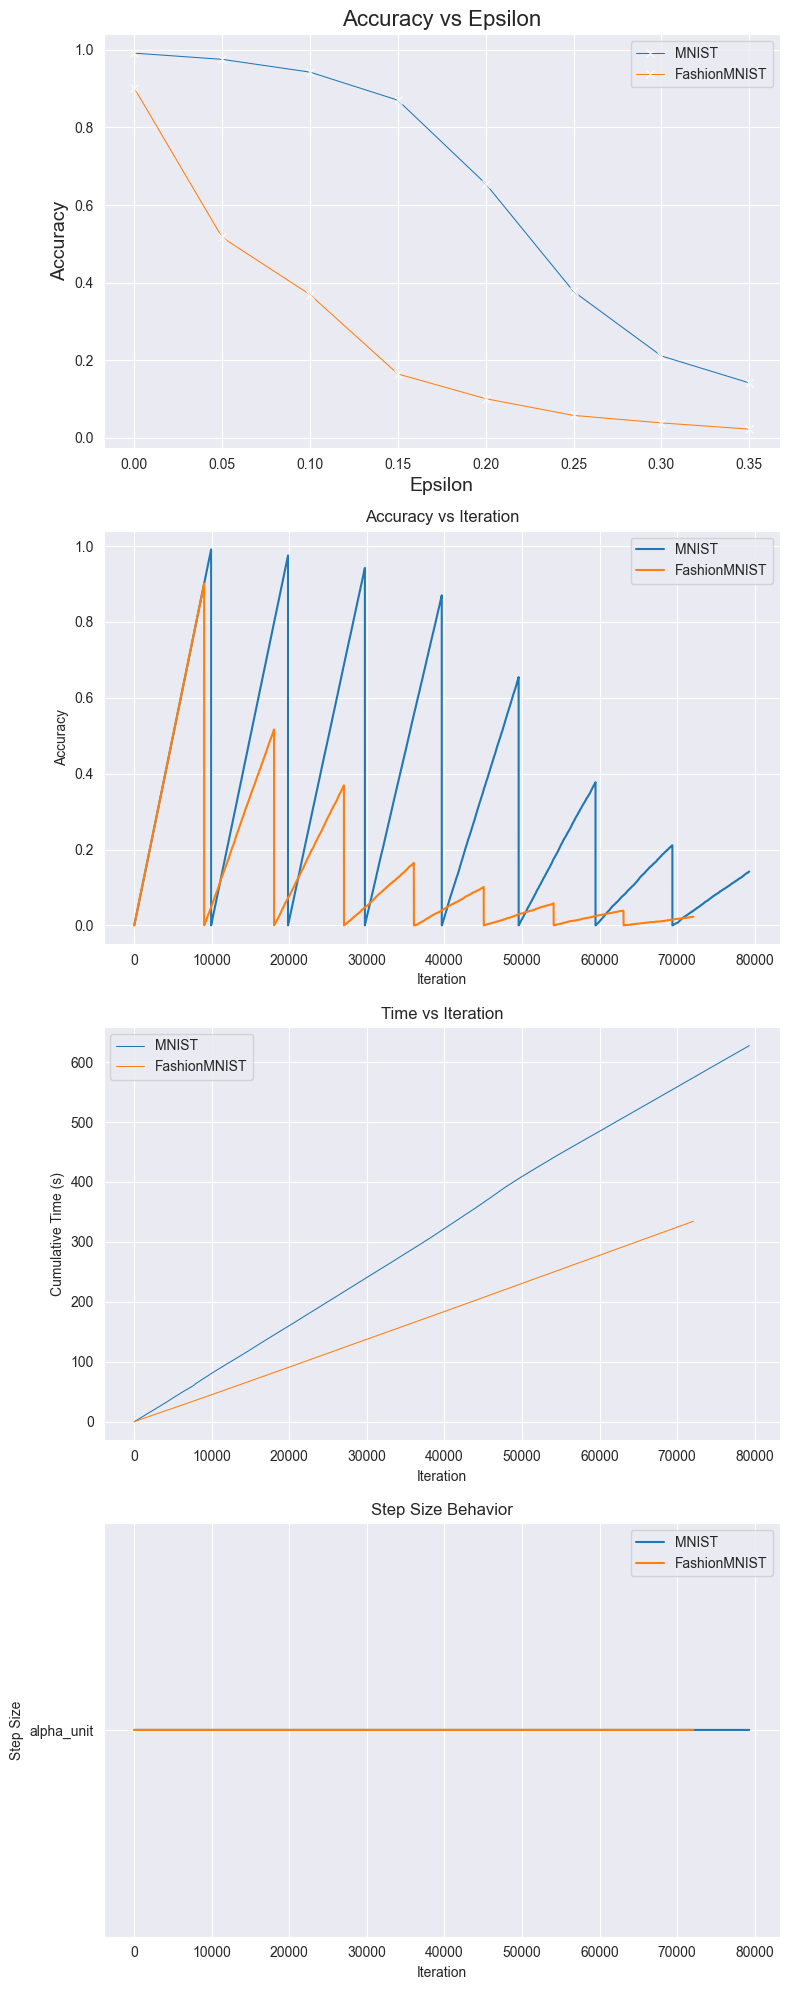

,Dataset,Epsilon,Accuracy,Iteration_Time,Step_Size
0,MNIST,0.00,0.9912,0.008998,alpha_unit
1,MNIST,0.05,0.9752,0.008005,alpha_unit
2,MNIST,0.10,0.9423,0.006000,alpha_unit
3,MNIST,0.15,0.8700,0.007001,alpha_unit
4,MNIST,0.20,0.6547,0.006998,alpha_unit
5,MNIST,0.25,0.3773,0.008002,alpha_unit
6,MNIST,0.30,0.2112,0.007997,alpha_unit
7,MNIST,0.35,0.1419,0.006000,alpha_unit
8,FashionMNIST,0.00,0.9011,0.005000,alpha_unit
9,FashionMNIST,0.05,0.5166,0.005000,alpha_unit


In [31]:
RUN(model_dict, device, test_loader_dict, PGD_const, num_iter, epsilons, 'alpha_unit')

##### Attack PGD lipschitz constant dependent step size

Dataset: MNIST
Epsilon: 0.00, Accuracy: 0.9912
Epsilon: 0.05, Accuracy: 0.9752
Epsilon: 0.10, Accuracy: 0.9416
Epsilon: 0.15, Accuracy: 0.8581
Epsilon: 0.20, Accuracy: 0.6361
Epsilon: 0.25, Accuracy: 0.3372
Epsilon: 0.30, Accuracy: 0.0935
Epsilon: 0.35, Accuracy: 0.0202
Dataset: FashionMNIST
Epsilon: 0.00, Accuracy: 0.9011
Epsilon: 0.05, Accuracy: 0.5086
Epsilon: 0.10, Accuracy: 0.3349
Epsilon: 0.15, Accuracy: 0.2286
Epsilon: 0.20, Accuracy: 0.1803
Epsilon: 0.25, Accuracy: 0.1491
Epsilon: 0.30, Accuracy: 0.1450
Epsilon: 0.35, Accuracy: 0.1450


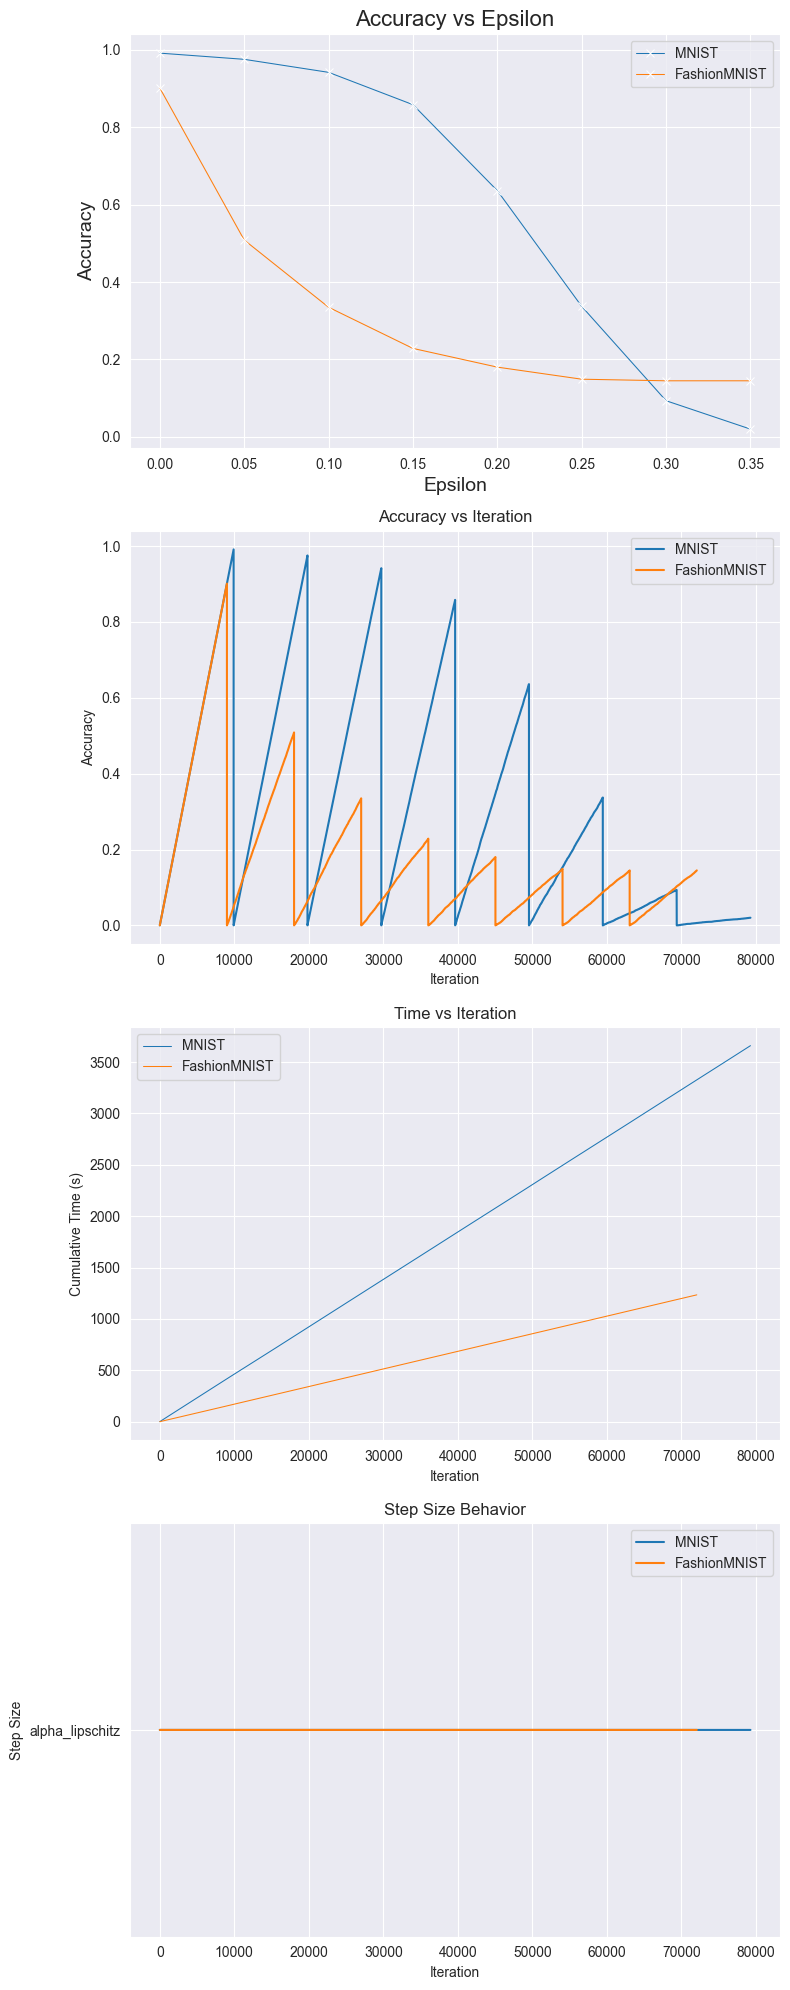

,Dataset,Epsilon,Accuracy,Iteration_Time,Step_Size
0,MNIST,0.00,0.9912,0.051002,alpha_lipschitz
1,MNIST,0.05,0.9752,0.052511,alpha_lipschitz
2,MNIST,0.10,0.9416,0.045002,alpha_lipschitz
3,MNIST,0.15,0.8581,0.048512,alpha_lipschitz
4,MNIST,0.20,0.6361,0.045996,alpha_lipschitz
5,MNIST,0.25,0.3372,0.050520,alpha_lipschitz
6,MNIST,0.30,0.0935,0.047004,alpha_lipschitz
7,MNIST,0.35,0.0202,0.047514,alpha_lipschitz
8,FashionMNIST,0.00,0.9011,0.019999,alpha_lipschitz
9,FashionMNIST,0.05,0.5086,0.015997,alpha_lipschitz


In [32]:
RUN(model_dict, device, test_loader_dict, PGD_const, num_iter, epsilons, 'alpha_lipschitz')

##### Attack PGD diminishing step size

Dataset: MNIST
Epsilon: 0.00, Accuracy: 0.9912
Epsilon: 0.05, Accuracy: 0.9752
Epsilon: 0.10, Accuracy: 0.9423
Epsilon: 0.15, Accuracy: 0.8700
Epsilon: 0.20, Accuracy: 0.6529
Epsilon: 0.25, Accuracy: 0.3480
Epsilon: 0.30, Accuracy: 0.1592
Epsilon: 0.35, Accuracy: 0.0779
Dataset: FashionMNIST
Epsilon: 0.00, Accuracy: 0.9011
Epsilon: 0.05, Accuracy: 0.5166
Epsilon: 0.10, Accuracy: 0.3693
Epsilon: 0.15, Accuracy: 0.1649
Epsilon: 0.20, Accuracy: 0.0857
Epsilon: 0.25, Accuracy: 0.0178
Epsilon: 0.30, Accuracy: 0.0026
Epsilon: 0.35, Accuracy: 0.0013


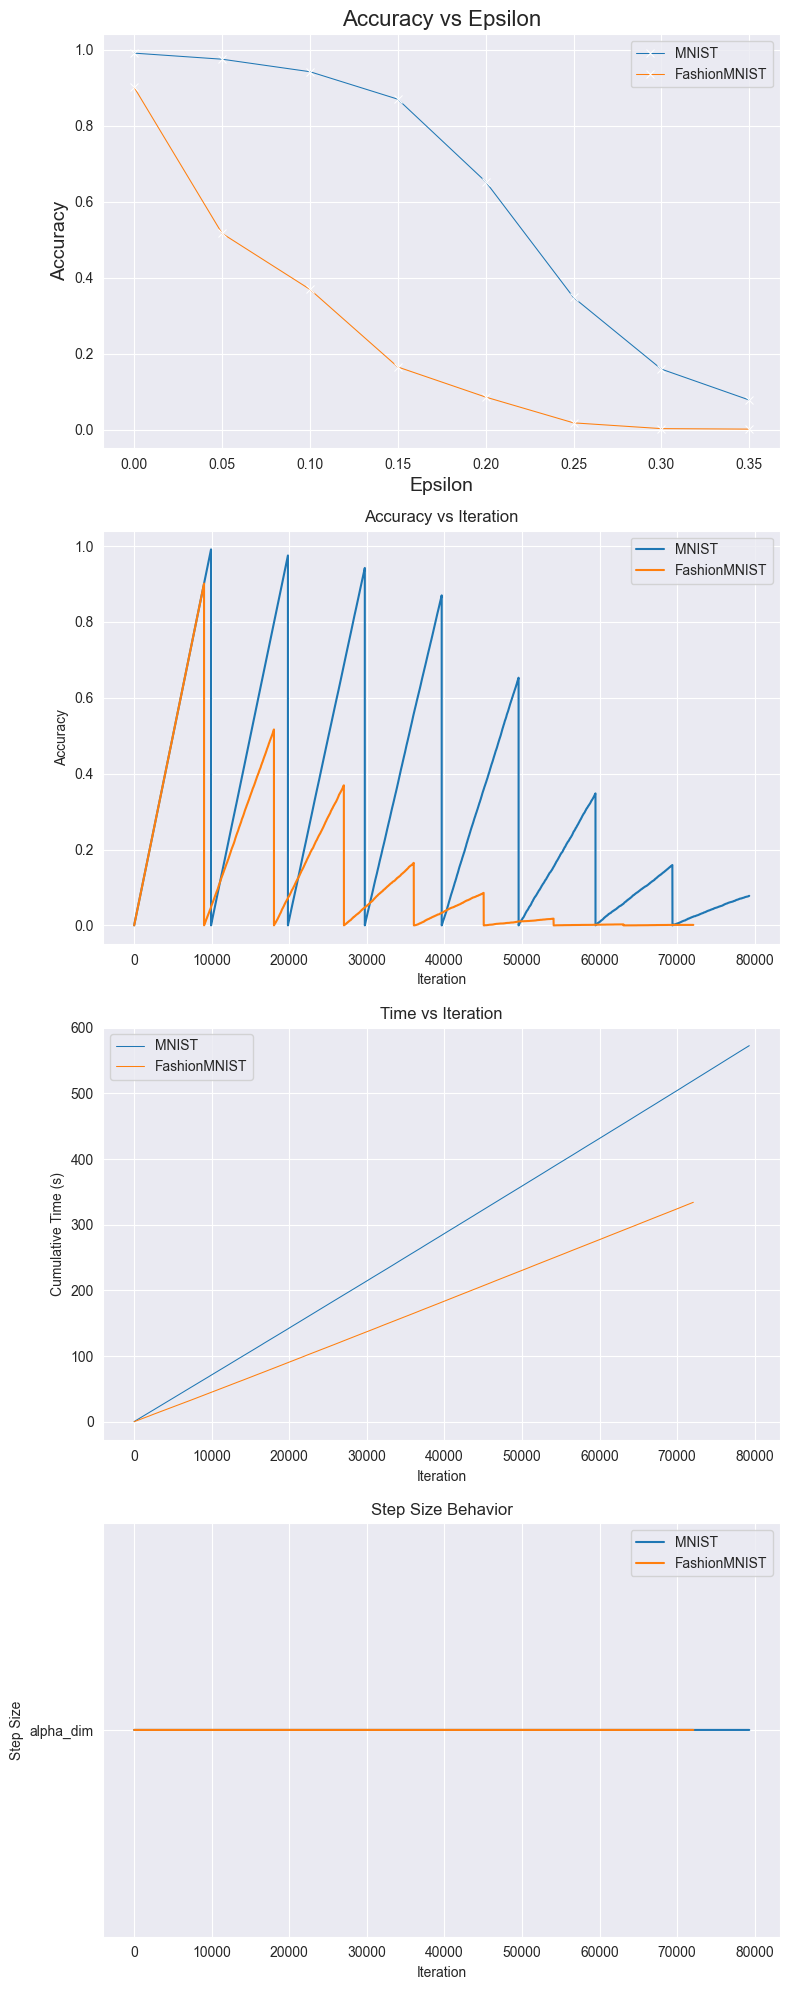

,Dataset,Epsilon,Accuracy,Iteration_Time,Step_Size
0,MNIST,0.00,0.9912,0.006998,alpha_dim
1,MNIST,0.05,0.9752,0.006004,alpha_dim
2,MNIST,0.10,0.9423,0.007002,alpha_dim
3,MNIST,0.15,0.8700,0.007000,alpha_dim
4,MNIST,0.20,0.6529,0.007000,alpha_dim
5,MNIST,0.25,0.3480,0.006999,alpha_dim
6,MNIST,0.30,0.1592,0.007000,alpha_dim
7,MNIST,0.35,0.0779,0.006002,alpha_dim
8,FashionMNIST,0.00,0.9011,0.004998,alpha_dim
9,FashionMNIST,0.05,0.5166,0.004006,alpha_dim


In [33]:
RUN(model_dict, device, test_loader_dict, PGD_adapt, num_iter, epsilons, "alpha_dim")

##### Attack PGD exact line search

Dataset: MNIST
Epsilon: 0.00, Accuracy: 0.9912
Epsilon: 0.05, Accuracy: 0.9912
Epsilon: 0.10, Accuracy: 0.9912
Epsilon: 0.15, Accuracy: 0.9912
Epsilon: 0.20, Accuracy: 0.9912
Epsilon: 0.25, Accuracy: 0.9912
Epsilon: 0.30, Accuracy: 0.9912
Epsilon: 0.35, Accuracy: 0.9912
Dataset: FashionMNIST
Epsilon: 0.00, Accuracy: 0.9011
Epsilon: 0.05, Accuracy: 0.9003
Epsilon: 0.10, Accuracy: 0.9003
Epsilon: 0.15, Accuracy: 0.9003
Epsilon: 0.20, Accuracy: 0.9003
Epsilon: 0.25, Accuracy: 0.9003
Epsilon: 0.30, Accuracy: 0.9003
Epsilon: 0.35, Accuracy: 0.9003


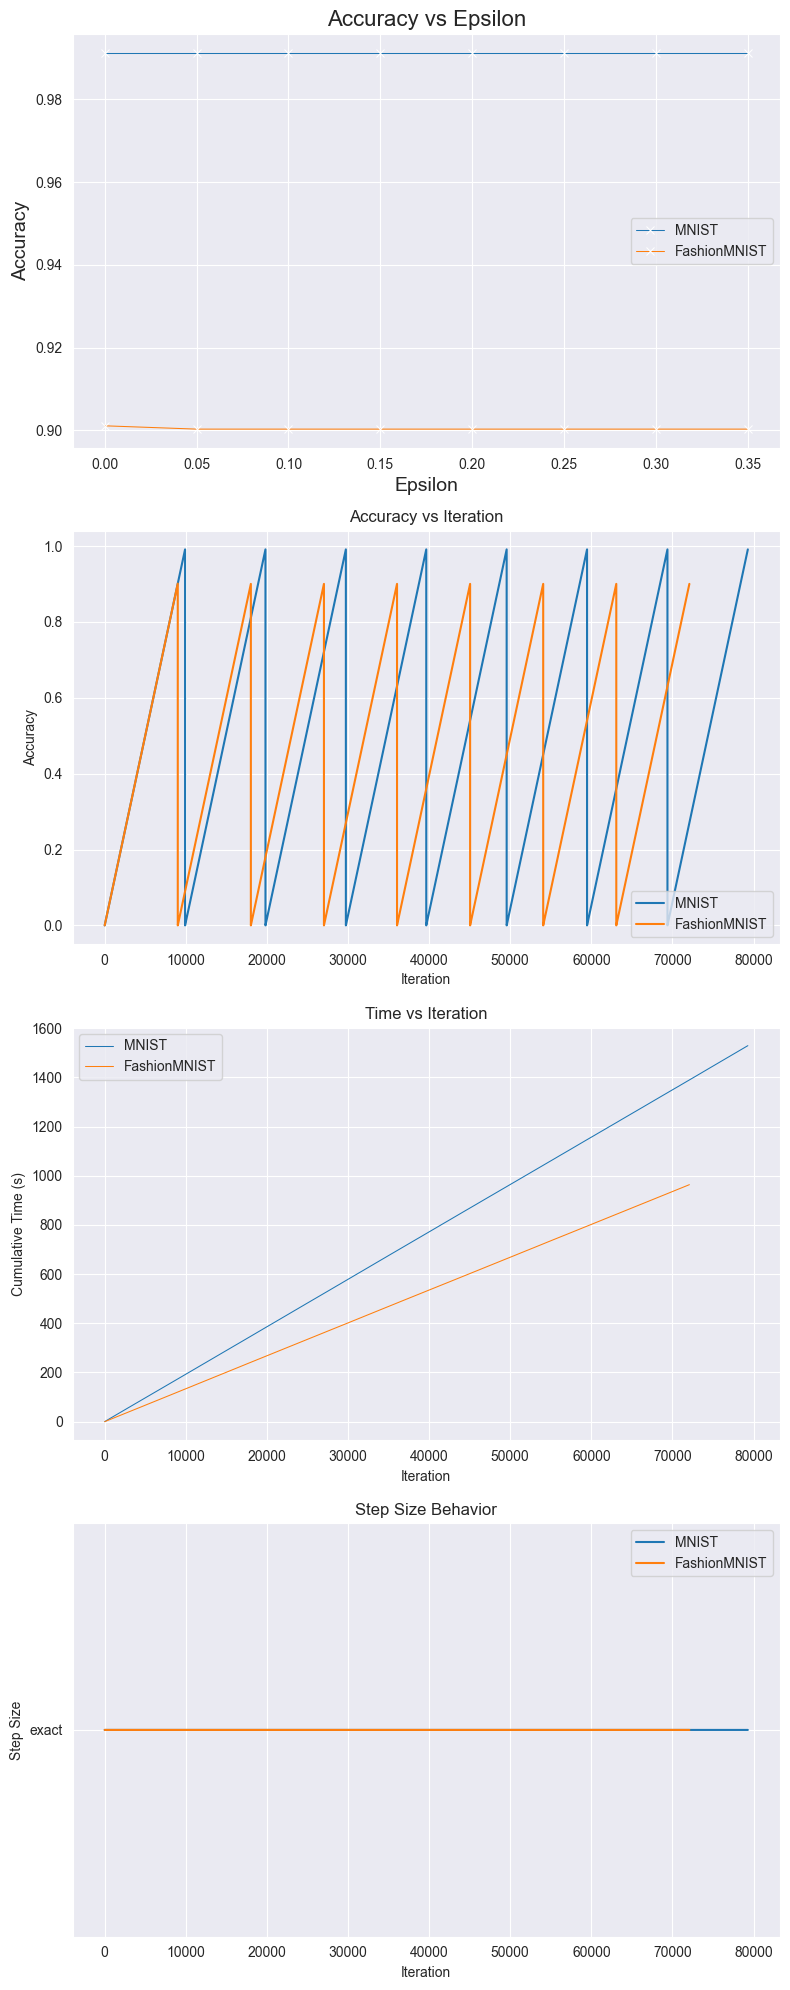

,Dataset,Epsilon,Accuracy,Iteration_Time,Step_Size
0,MNIST,0.00,0.9912,0.023004,exact
1,MNIST,0.05,0.9912,0.018511,exact
2,MNIST,0.10,0.9912,0.019000,exact
3,MNIST,0.15,0.9912,0.018000,exact
4,MNIST,0.20,0.9912,0.022002,exact
5,MNIST,0.25,0.9912,0.023512,exact
6,MNIST,0.30,0.9912,0.020000,exact
7,MNIST,0.35,0.9912,0.026000,exact
8,FashionMNIST,0.00,0.9011,0.013005,exact
9,FashionMNIST,0.05,0.9003,0.011512,exact


In [34]:
RUN(model_dict, device, test_loader_dict, PGD_adapt, num_iter, epsilons, "exact")

##### Attack PGD armijo rule

Dataset: MNIST
Epsilon: 0.00, Accuracy: 0.9912
Epsilon: 0.05, Accuracy: 0.9912
Epsilon: 0.10, Accuracy: 0.9912
Epsilon: 0.15, Accuracy: 0.9912
Epsilon: 0.20, Accuracy: 0.9912
Epsilon: 0.25, Accuracy: 0.9912
Epsilon: 0.30, Accuracy: 0.9912
Epsilon: 0.35, Accuracy: 0.9912
Dataset: FashionMNIST
Epsilon: 0.00, Accuracy: 0.9011
Epsilon: 0.05, Accuracy: 0.9001
Epsilon: 0.10, Accuracy: 0.9001
Epsilon: 0.15, Accuracy: 0.9001
Epsilon: 0.20, Accuracy: 0.9001
Epsilon: 0.25, Accuracy: 0.9001
Epsilon: 0.30, Accuracy: 0.9001
Epsilon: 0.35, Accuracy: 0.9001


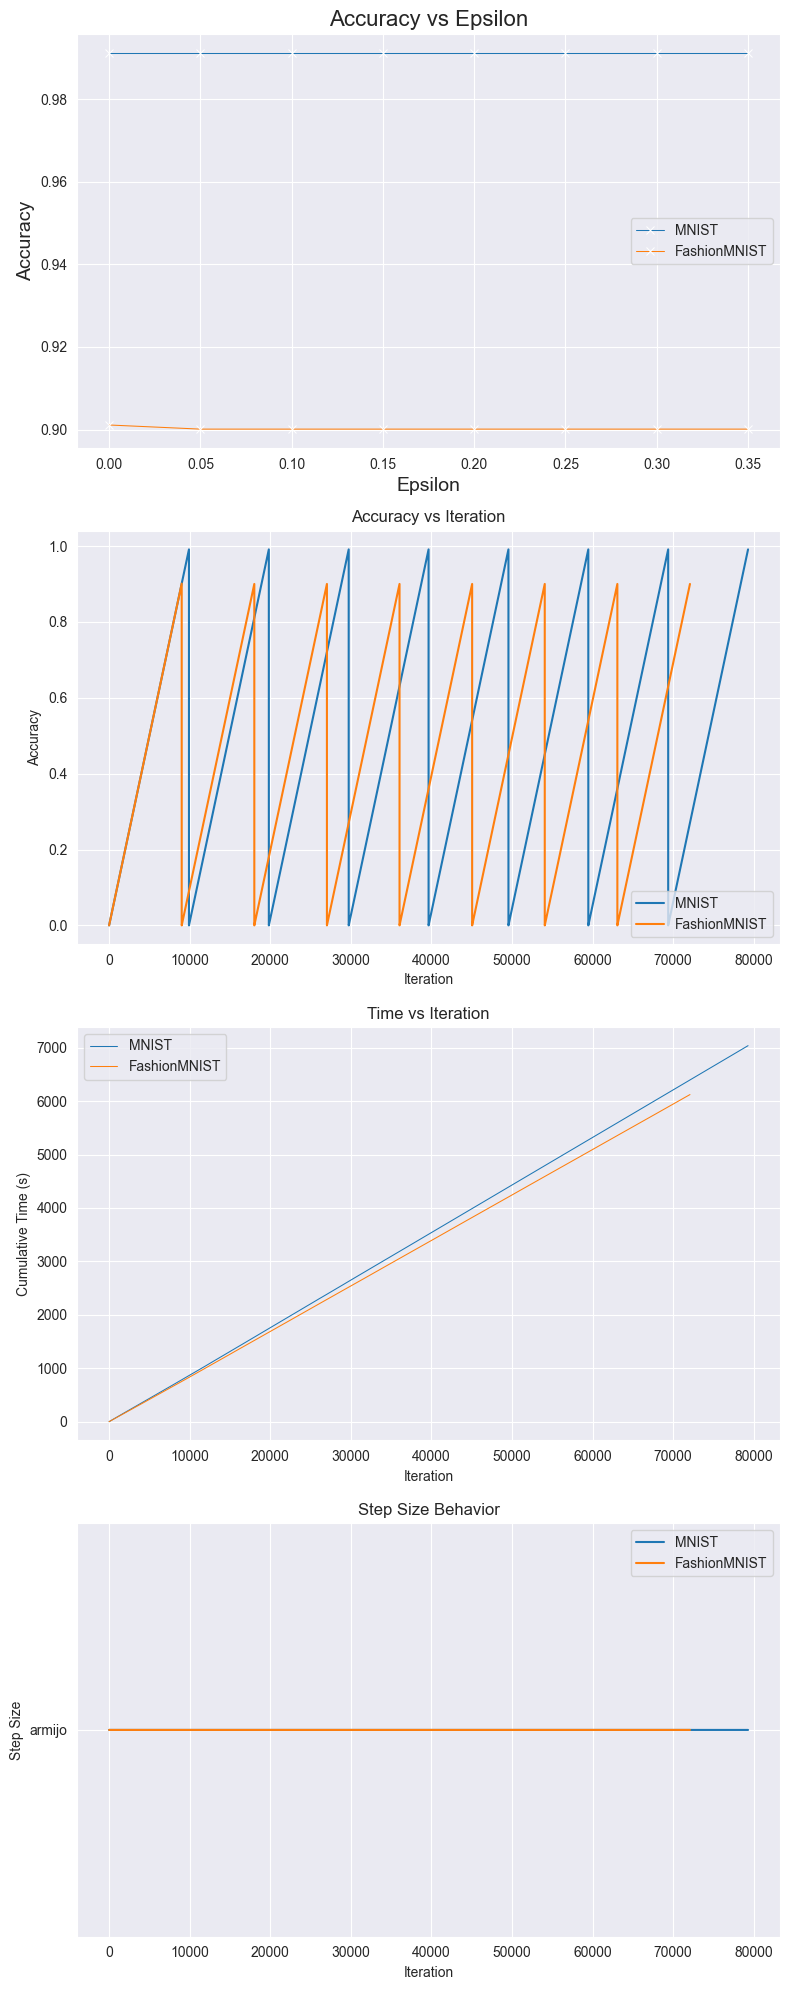

,Dataset,Epsilon,Accuracy,Iteration_Time,Step_Size
0,MNIST,0.00,0.9912,0.095529,armijo
1,MNIST,0.05,0.9912,0.093540,armijo
2,MNIST,0.10,0.9912,0.098512,armijo
3,MNIST,0.15,0.9912,0.119525,armijo
4,MNIST,0.20,0.9912,0.084530,armijo
5,MNIST,0.25,0.9912,0.079516,armijo
6,MNIST,0.30,0.9912,0.267570,armijo
7,MNIST,0.35,0.9912,0.097521,armijo
8,FashionMNIST,0.00,0.9011,0.093512,armijo
9,FashionMNIST,0.05,0.9001,0.063517,armijo


In [35]:
RUN(model_dict, device, test_loader_dict, PGD_adapt, num_iter, epsilons, "armijo")

## Attack FSGM

In [36]:
# MODIFIED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# no step size since it is not an iterative method
# changelog:
# added model, target, data_grad, alpha and num_iter parameters to the function signature to fit it to the test function

# FGSM attack code
def FSGM_attack(image, epsilon, data_grad):
    # Collect the element-wise sign of the data gradient
    sign_data_grad = data_grad.sign()
    # Create the perturbed image by adjusting each pixel of the input image
    perturbed_image = image + epsilon*sign_data_grad
    # Adding clipping to maintain [0,1] range
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    # Return the perturbed image
    return perturbed_image

Running FGSM Attack
Epsilon: 0, Accuracy: 0.99
Epsilon: 0.05, Accuracy: 0.96
Epsilon: 0.1, Accuracy: 0.87
Epsilon: 0.15, Accuracy: 0.71
Epsilon: 0.2, Accuracy: 0.48
Epsilon: 0.25, Accuracy: 0.27
Epsilon: 0.3, Accuracy: 0.14
Epsilon: 0.35, Accuracy: 0.08


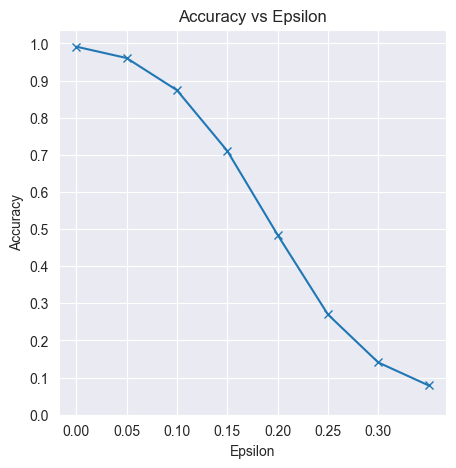

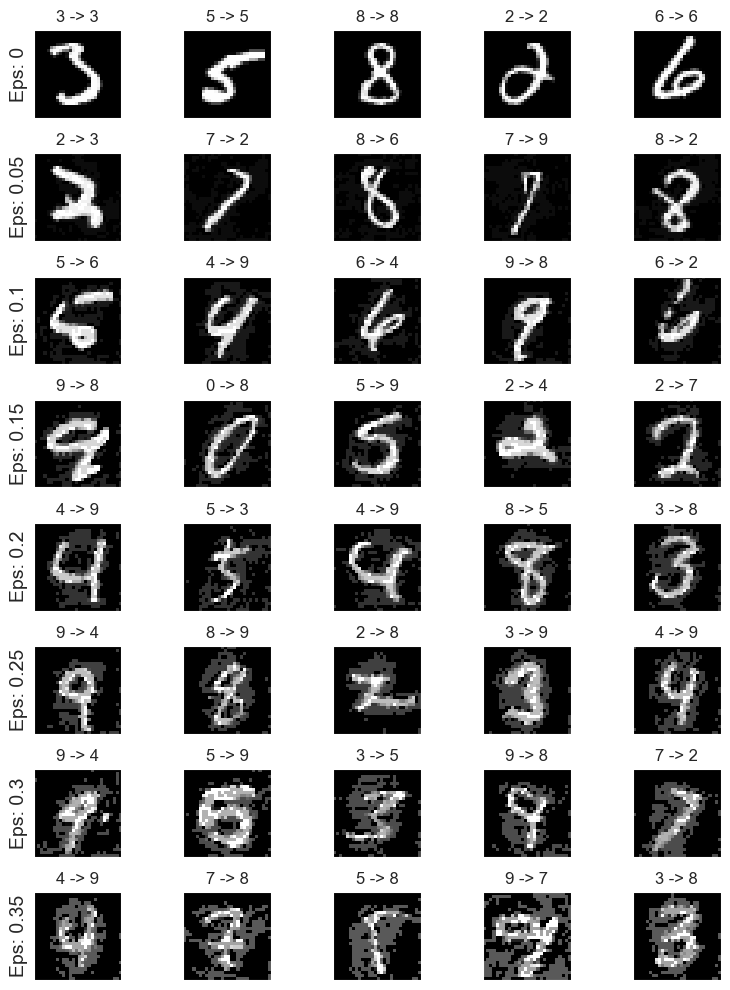

In [37]:
# since it is not an iterative model, we can't plot time per iteration and accuracy per iteration metrics, so we'll use raw code
# MODIFIED from https://pytorch.org/tutorials/beginner/fgsm_tutorial.html
# changelog:
# fit the function to the test function's if statement, with of course None as step size and number of iterations
## test function may be further slimmed by avoiding some repetition putting the if statement somewhere else, but it's not a big deal

# Run test for each epsilon
### modified to fit the test function and to print eps and acc more concisely like the other RUN function
def RUN_FSGM(model, device, test_loader, epsilons):
    accuracies = []
    examples = []

    print("Running FGSM Attack")
    for eps in epsilons:
        acc, ex, _, _, _ = test(model, device, test_loader, eps, 'FSGM_attack', None, None)
        accuracies.append(acc)
        examples.append(ex)
        print(f"Epsilon: {eps}, Accuracy: {acc:.2f}")
        
    plt.figure(figsize=(5, 5))
    plt.plot(epsilons, accuracies, "x-")
    plt.yticks(np.arange(0, 1.1, step=0.1))
    plt.xticks(np.arange(0, .35, step=0.05))
    plt.title("Accuracy vs Epsilon")
    plt.xlabel("Epsilon")
    plt.ylabel("Accuracy")
    plt.show()

    plot_examples(examples, epsilons)

# Example usage
RUN_FSGM(mnist_model, device, mnist_test_loader, epsilons)

# FW (and variants) Attacks

In [38]:
# Define FW step functions
def fw_step(x_t, epsilon, g_t, x0, stepsize_method):
    g_t_sign = g_t.sign()
    v_t = -epsilon * g_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    gap_FW = torch.sum(-d_t * g_t).item()
    return perturbed_image, gap_FW

def fw_step_altgap(x_t, epsilon, g_t, x0, stepsize_method):
    g_t_sign = g_t.sign()
    v_t = -epsilon * g_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    gap_FW = torch.sum(-(perturbed_image - x_t)*g_t).item()
    return perturbed_image, gap_FW

def fw_step_momentum(x_t, epsilon, g_t, m_t_last, x0, stepsize_method, momentum = 0.2):
    m_t = (1 - momentum) * g_t
    if m_t_last is not None:
        m_t += momentum * m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t

    # determine stepsize
    if stepsize_method.strat == 'ls':
        fw_stepsize = stepsize_method.stepsize_linesearch(x_t, d_t)
    else:
        fw_stepsize = stepsize_method.stepsize

    gap_FW = torch.sum(-d_t * g_t).item()
    perturbed_image = x_t + fw_stepsize * d_t
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t, gap_FW

def fw_step_momentum1(x_t, epsilon, g_t, m_t_last, x0, momentum = 0.2, fw_stepsize = 1):
    m_t = (1 - momentum) * g_t
    if m_t_last is not None:
        m_t += momentum * m_t_last
    m_t_sign = m_t.sign()
    v_t = -epsilon * m_t_sign + x0
    d_t = v_t - x_t
    perturbed_image = x_t - momentum * epsilon * m_t_sign - momentum * (x_t - x0)
    perturbed_image = torch.clamp(perturbed_image, 0, 1)
    return perturbed_image, m_t

# Modified test function to include FW algorithms
def test_fw(model, device, test_loader, epsilon, fw_algo, stepsize_method, momentum=None):
    model.eval()
    correct = 0
    adv_examples = []
    iteration_accuracies = []
    step_sizes = []
    iteration_times = []

    for data, target in test_loader:
        data, target = data.to(device), target.to(device)
        data.requires_grad = True
        output = model(data)
        init_pred = output.max(1, keepdim=True)[1]

        if init_pred.item() != target.item():
            continue

        loss = F.nll_loss(output, target)
        model.zero_grad()
        loss.backward()
        data_grad = data.grad.data
        data_denorm = denorm(data)

        start_time = time.time()
        if fw_algo == 'fw_step':
            perturbed_data, _ = fw_step(data_denorm, epsilon, data_grad, data_denorm, stepsize_method)
        elif fw_algo == 'fw_step_altgap':
            perturbed_data, _ = fw_step_altgap(data_denorm, epsilon, data_grad, data_denorm, stepsize_method)
        elif fw_algo == 'fw_step_momentum':
            perturbed_data, _, _ = fw_step_momentum(data_denorm, epsilon, data_grad, None, data_denorm, stepsize_method, momentum)
        else:
            perturbed_data, _ = fw_step_momentum1(data_denorm, epsilon, data_grad, None, data_denorm, momentum)

        iteration_time = time.time() - start_time
        perturbed_data_normalized = transforms.Normalize((0.1307,), (0.3081,))(perturbed_data)
        output = model(perturbed_data_normalized)
        final_pred = output.max(1, keepdim=True)[1]

        if final_pred.item() == target.item():
            correct += 1
            if epsilon == 0 and len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))
        else:
            if len(adv_examples) < 5:
                adv_ex = perturbed_data.squeeze().detach().cpu().numpy()
                adv_examples.append((init_pred.item(), final_pred.item(), adv_ex))

        iteration_accuracies.append(correct / float(len(test_loader)))
        step_sizes.append(stepsize_method.stepsize if stepsize_method.strat != 'ls' else 'line_search')
        iteration_times.append(iteration_time)

    final_acc = correct / float(len(test_loader))
    return final_acc, adv_examples, iteration_accuracies, step_sizes, iteration_times


# Post requirements ideas

#### grid search

grid search params:

get:
	num_iters
	delta (armijo)
	gamma (armijo)

such that:
	minimize eps
	minimize time
	maximize accuracy